# Out-of-plane failure calculations
### G-Mechanism (triangular) with windows (D'Ayala, 2002)

## Introduction

This notebook can be used to calculate the push-over curve for a basic out-of-plane mechanisms of a masonry structure subject to seismic action. First, the geometric and material characteristics will be defined, then depending on these inputs, the displacement capacity for out-of-plane accelerations will be returned in form of a push-over graph. 

This is a generic case of a wall failing symmetrically in two triangular blocks with cracks in the diagonal of the windows as shown in the figure below.

In [ ]:
# Import the basic packages for the notebook
import numpy as np # Numerical library
import pandas as pd # Data analysis library
import matplotlib.pyplot as plt # Plotting library
import matplotlib.ticker as maticker 
import sys

## 1. Define the wall geometry

The chosen example for this code is a plain wall moving out of plane around two diagonal axes. A sketch with the main dimensions is shown below. The displacement delta is measured at the center of the wall.

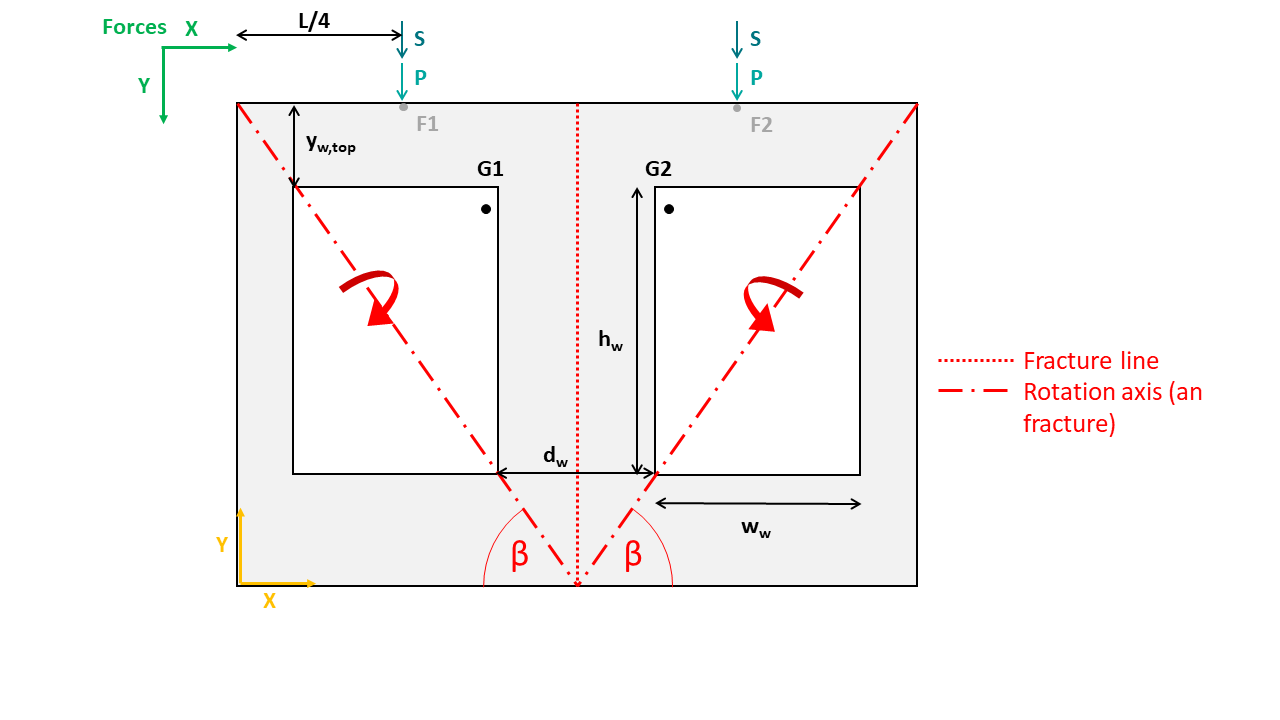

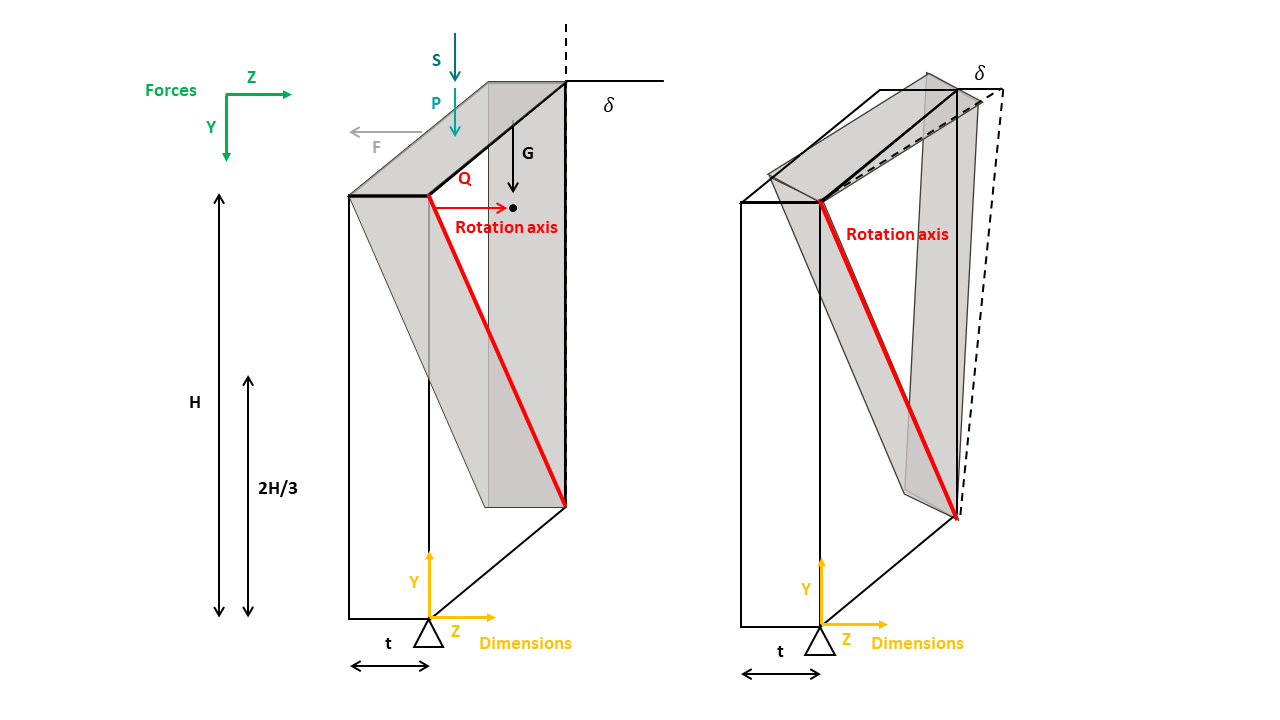

In [ ]:
### NOTHING TO BE CHANGED
from IPython.display import Image, display
display(Image(filename='Mec_G_3.png'))
display(Image(filename='Mec_G_2.png'))

This block is used to define the geometry of the wall and the windows within. You can adapt the input to use the notebook for your case.

In [ ]:
## Wall geometry
y_w_top = 0.5       # Free space above window (until reaching next floor), y-direction [m]
d_w = 1.4           # Horizontal distance between the windows in the mechanism,x-direction [m]
h_w = 1.2           # Height of the window, y-direction [m]
w_w = 1.1           # Width of the window, x-direction
t = 0.5             # Thickness of wall,    z-direction [m]
# since it is a symmetric mechanism, it is considered that the cracks go from the upper limit of the wall, through
# the two diagonal corners of a window until reaching the crack from the other side.

## Slab information
max_delta = 0.1     # Maximum drift (at the center crack), when the slab and wall loose connection and the friction between the two of them 
                    # is no longer restraining the wall [m]

## 2. Define material properties

This block is used to define the material properties of the wall and the connecting slab. You can adapt the input to use the notebook for different cases.

In [ ]:
rho_masonry = 18000         # Density of the masonry [N/m^3]
mu_f = 0.6                  # Friction coefficient between slab and masonry wall

## 3. Define the loads and forces

In this paragraph, the loads and forces acting on the wall are defined. The following block defines the vertical load on top of the wall coming from a slab (S) or a superimposed wall (P). Note that the S-load will be used to directly calculate the restraining force due to friction between the wall and the slab. If you want to introduce a vertical load that does not produce any friction, please use the P-load.

In [ ]:
P = 100000               # vertical load on top of the left side [N]
S = 00000               # slab load acting on top of the left side [N]


## 4. Calculation of overturning moment

This paragraph calculates the pushover curve for the given case. Nothing needs to be changed here.

Text(0.5, 1.0, 'a - Displacement')

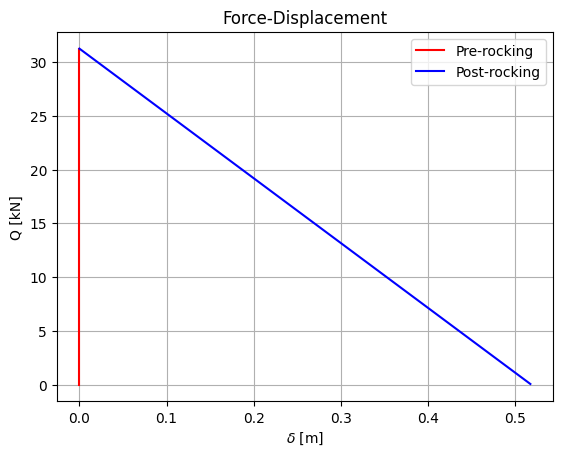

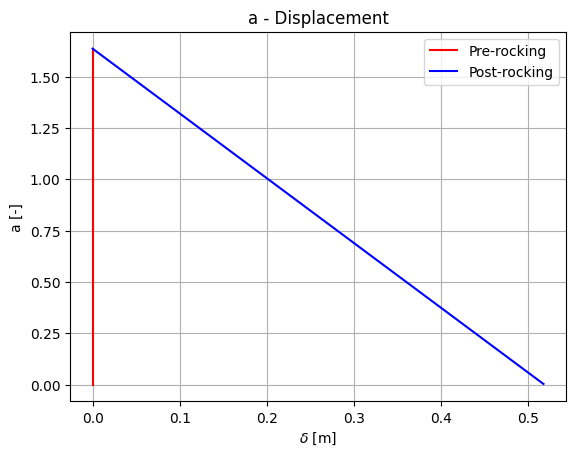

In [ ]:
### NOTHING TO BE CHANGED

# This function calculates lever arm between the center of gravity of a triangular wall and the rotation axis
def lever_arm(x,y):
    # H   = Total height of wall, y-direction [m]
    # L   = Total length of wall, x-direction [m]
    # t   = Thickness of wall,    z-direction [m]
    # x   = X-coordinate of the point for which the lever arm is searched [m]
    # y   = Y-coordinate of the point for which the lever arm is searched [m]
    y_top = H - y # Distance from top edge to center of gravity
    if x <= L/2:
        z_lever = (x * np.sin(beta)) - (y_top * np.cos(beta))
    else:
        x_bar = L-x 
        z_lever = (x_bar * np.sin(beta)) - (y_top * np.cos(beta))

    return z_lever

# This function calculates the center of gravity of the moving triangular block, considering the opening of the window
def COG_calc():
    # H          = Total height of wall, y-direction [m]
    # L          = Total length of wall, x-direction [m]
    # t          = Thickness of wall,    z-direction [m]
    # h_w        = Height of the window, y-direction [m]
    # w_w        = Width of the window,  x-direction [m]
    # x_w        = Distance between outer window edge and end of mechanism (horizontal) [m]
    # y_w_top    = Distance between upper edge of window and floor (vertical) [m]
    # y_w_bottom = Distance between bottom edge of window and end of mechanism (vertical)[m]
    # d_w        = Distance between the windows [m]
    COG_wall = np.array([L/3,2*H/3])
    COG_window = np.array([x_w + (2*w_w/3),y_w_bottom + (2*h_w/3)])

    V_brut = H*L/4*t                            # volume of the moving wall block[m3]
    V_window =h_w*w_w/2*t                       # volume of opening in moving block [m3]
    V_net = V_brut - V_window                   # volume of the moving block without window volume [m3]

    COG_tot= ((COG_wall * V_brut) - (COG_window*V_window))/V_net
    return COG_tot

# This function calculates the maximum horizontal force that can be applied to the wall at a given deformation delta 
# to stay in an equilibrium state
def Q_eq_fun(delta): 
    # delta        = Displacement at the top of the wall [m]
    # t            = Thickness of the wall [m]
    # H            = Total height of the wall [m]
    # COG_y_wall   = Y-coordinate of the center of gravity of the wall [m]
    # P            = Vertical load on top of the wall [N]
    # S            = Slab load acting on top of the wall [N]
    # G            = Gravity load of the wall (self-weight) [N]
    # F            = Friction force from slab acting on top of the wall [N]
    z_top_center = lever_arm(L/4,H)
    z_cog = lever_arm(COG[0],COG[1])
    z_delta = lever_arm(L/2,H)

    delta_top_center = delta * z_top_center / z_delta
    delta_cog = delta * z_cog / z_delta

    # The projected parts of the actions that will create a moment around the turning axis
    P_proj = P * np.cos(beta)
    S_proj = S * np.cos(beta)
    G_proj = G * np.cos(beta)
    if delta < max_delta:
        F_proj = F
    else:
        F_proj = 0


    # The moment created by each action, positive = destabilizing, negative = stabilizing
    M_P = P_proj * (delta_top_center - t/2)
    M_S = S_proj * (delta_top_center - t/2)
    M_G = G_proj * (delta_cog - t/2)
    M_F = F_proj * z_top_center

    Q_eq = -(M_P + M_S + M_G + M_F) / z_cog # Maximum earthquake force for equilibrium [N]
    
    return Q_eq

## Derived wall properties
beta = np.arctan(h_w/w_w)                   # angle of the crack
x_w = y_w_top / np.tan(beta)                # horizontal distance from corner of window to outer end of crack [m]
y_w_bottom = d_w / 2 * np.tan(beta)         # vertical distance from bottom of window to crack intersection [m]
H = h_w + y_w_top + y_w_bottom              # total height of the mechanism [m]
L = 2 * (w_w + x_w) + d_w                   # total length of the mechanism [m]

V_brut = H*L/4*t                            # volume of the moving wall block[m3]
V_window =h_w*w_w/2*t                       # volume of opening in moving block [m3]
V_net = V_brut - V_window                   # volume of the moving block without window volume [m3]

COG = COG_calc()                            # center of gravity of the moving block (x,y) [m]


## Derived loads and forces
G = rho_masonry*V_net                       # gravity load of the triangular wall (self-weight) [N]
F = -mu_f*S                                 # friction force from slab acting on top of the  wall [N]

## Rocking of the left side
# Maximum earthquake force to start rocking the left side
Q_max = Q_eq_fun( 0)                        # Maximum seismic load [N]
alpha_max  = Q_max/G                        # Portion of gravity load [-]

# Plot force-displacement relationship of the left overturning of the wall
delta_vals = np.linspace(0,H,1000)
q_vals = np.zeros((np.size(delta_vals)))

for i in range(np.size(delta_vals)):       # Calculates the corresponding force for the given displacement
    q_vals[i]=Q_eq_fun(delta_vals[i])/1000
# Transformation to only display values up to failure
q_vals = q_vals[q_vals>=0]
delta_vals = delta_vals[: np.size(q_vals)]

plt.figure()
plt.grid()
plt.plot([0,0],[0,Q_max/1000],label='Pre-rocking',color='red')
plt.plot(delta_vals,q_vals,label='Post-rocking', color='blue')
plt.legend()
plt.xlabel('$\delta$ [m]')
plt.ylabel('Q [kN]')
plt.title('Force-Displacement')



# Plot acceleration-displacement relationship of the overturning of the wall, where alpha is a factor multiplied
# by gravitational acceleration
alpha_vals = q_vals / G *1000 # Transformation to alpha value

plt.figure()
plt.grid()
plt.plot([0,0],[0,alpha_max],label='Pre-rocking',color='red')
plt.plot(delta_vals,alpha_vals,label='Post-rocking',color='blue')
plt.legend()

plt.xlabel('$\delta$ [m]')
plt.ylabel('a [-]')
plt.title('a - Displacement')

## 5. Computation of capacity curve

This section will allow you to analyze the structural response in the context of the seismic spectrum. The goal is to compare the capacity curve to the response spectrum, which will allow the behaviour of the wall to be interpreted (e.g., indicating whether it would meet its design requirements).

The main input is the spectral acceleration (for a 475-year return period) for the wall in its given location, as well as its period. For users of the Swiss code, SIA 261 chapter 16.2.1.2 provides the horizontal soil acceleration for each seismic zone; otherwise it can be found in the relevant National Annex of the Eurocode. The period can be computed by calculating the mass and total stiffness (dependent on both flexural and shear stiffness), through an approximation such as the one found in SIA 261 16.5.2.3., or a modal analysis.

As stated above, this section will provide an interpretation of the wall's behavior according to a trilinear force-displacement model. These model utilizes three points: two displacement parameters, delta_1 and delta_2, and the maximum displacement capacity, delta_o. Below, the trilinear approximation as determined by Griffith et al. (2003) is plotted alongside the bilinear relationship and the real semi-rigid nonlinear relationship. According to Griffith et al. (2003), these coefficients depend on the material quality. Note that for this notebook, delta_u is approximated to be equivalent to delta_o in this code.

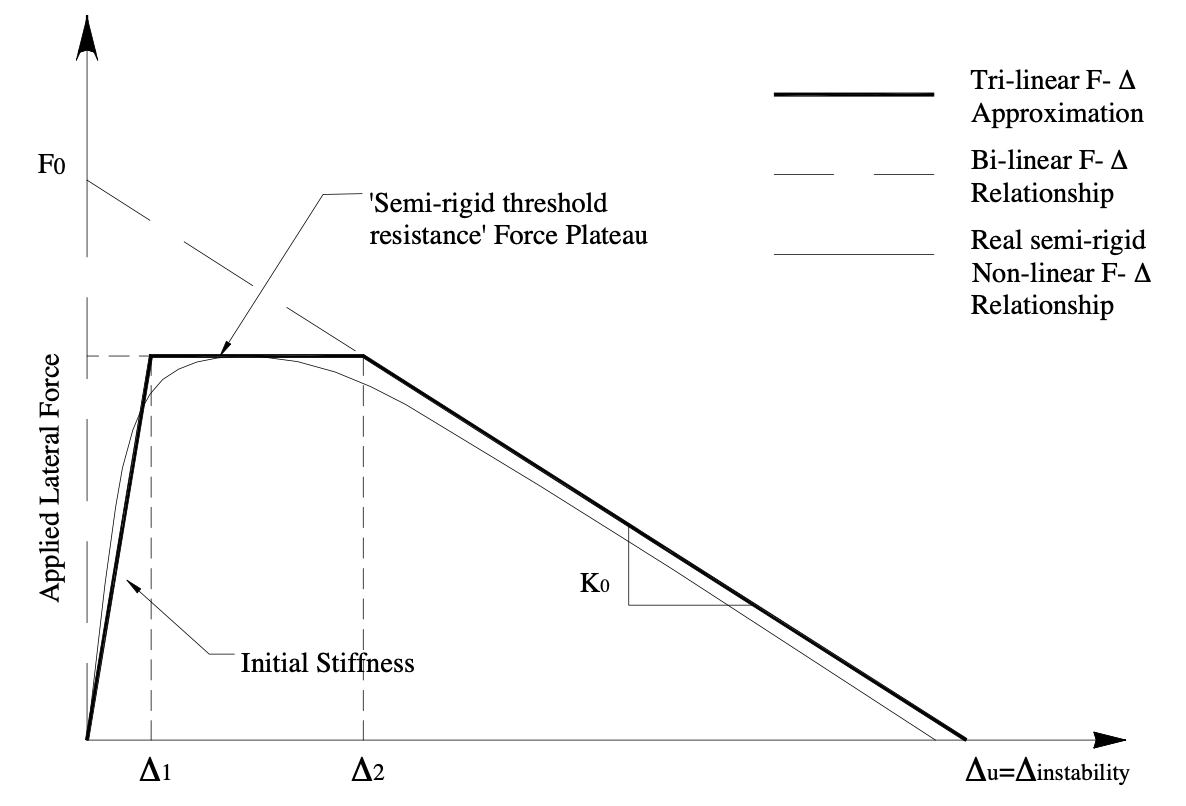

In [ ]:
display(Image(filename='Griffith_Trilinear.png'))

In [ ]:
agr = 0.195           # Horizontal soil acceleration [g]
T = 0.59              # Fundamental period of building [s]

# Choose the coefficients for the trilinear model per Griffith et al. (2003)
d1 = 0.125            # Range from 0.05 to 0.20
d2 = 0.375            # Range from 0.25 to 0.50

Response spectra are defined for single degree of freedom (DOF) systems. In this case, the mechanism only involves one DOF. The calculation for transforming a multiple DOF mechanism to a single DOF is still carried out below. 

In [ ]:
### NOTHING TO BE CHANGED

z_top_center = lever_arm(L/4,H)
z_cog = lever_arm(COG[0],COG[1])
z_delta = lever_arm(L/2,H)

g = 9.81                                                       # gravitational constant [m/s^2]
m = np.array([V_net*rho_masonry/g,V_net*rho_masonry/g])        # masses of wall parts [kg]

Qs = np.sum(m)*agr*g                                            # seismic force acting at the gravity center of the 
                                                                # wall [N]

# normalize accelerations
acc_top = 1
acc_norm = (acc_top/H)*z_cog                                   # normalized acceleration [m/s^2]

Delta_top = 1                                                  # displacement capacity [m]

# calculate effective properties
m_star = (np.sum(acc_norm*m)**2)/np.sum((acc_norm**2)*m)       # effective mass (SDOF) [kg]
h_star = np.sum(z_cog*acc_norm*m)/np.sum(acc_norm*m)           # effective height (SDOF) [m]
a_star = agr*np.sum(m)*g/m_star                                # effective acceleration (SDOF) [m/s^2]
Gamma = 1/(np.sum((acc_norm**2)*m)/np.sum(acc_norm*m))         # participation factor [-]
Delta_star = Delta_top/Gamma                                   # effective displacement (SDOF) [m]

To compute the response spectrum, it is necessary to specify the soil type per SIA 261 Tableau 24 or the Eurocode National Annex for a particular country. In the following code, the spectra are defined according to the Swiss codes, but it can be easily updated to reflect the country of your choosing. 

Alternatively, sometimes the response spectra are defined according to the limit state for analysis. The available limit states are: 'serviceability', 'damage limitation', 'significant damage' or 'near collapse. If the response spectra are independent of the limit state (for example, as is the case when using SIA 261), simply compute the resistance of the wall according to its limit state. More information can be found in EC 8 chapter 4.2.3. 

Finally, since this notebook works for a generalized case, the q-factor approach is not used. The use of the q-factor approach is dependent on the conditions described in 11.3.2.3, and hence to keep the calculation as useful as possible, the following spectra are elastic. 

After the computation of the response spectrum, the capacity curve can be plotted alongside the acceleration-displacement response spectrum. This provides a direct comparison between the specific behavior of the elements in question (in this case, the wall) and the spectrum of the desired limit state (either serviceability state, damage limitation, significant damage, or near collapse), and it can quickly give the spectral acceleration for a certain spectral displacement. 

This displacement-based evaluation utilizes the equal displacement "rule" for periods smaller than T_c and the equal energy "rule" for periods larger than T_c. Thus, to interpret the results, extend the initial positive linear part of the capacity curve until it intersects the ADRS, and draw a vertical line at this intersection. If T < T_c, the actual displacement will be slightly larger than the displacement at the intersection of the capacity curve and the vertical line; if T > T_c, the actual displacement will be equivalent to the displacement at the intersection of the capacity curve and the vertical line. The displacement capacity is exceeded if the determined displacement is larger than the end of the capacity curve. 

In [ ]:
soil_type = 'A'        # specify the soil type (ranging from A to E)

In [ ]:
### NOTHING TO BE CHANGED

## Determine the periods that define the spectrum according to the soil type, with values from SIA 261 Tab. 24
def spectrum_vals(soil_type): 
    if soil_type == 'A':
        S = 1.00                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.40                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'B':
        S = 1.20                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'C':
        S = 1.15                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.60                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'D':
        S = 1.35                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.80                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'E':
        S = 1.40                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    
    return S,Tb,Tc,Td

## Determine the spectral acceleration according to the structure's fundamental period
def RS(T,agr,S,Tb,Tc,Td):

    # determine spectral ground acceleration for dimensionning 
    g = 9.81                                     # [m/s^2]
    agd = agr*g                                  # [m/s^2]
    zeta = 0.05                                  # assume damping ratio to be 5% [-]
    eta = max(np.sqrt(1/(0.5+10*zeta)),0.55)     # reduction coefficent [-]

    # compute spectrum according to period
    if T<Tb: 
        Se = agd*S*(1+(T/Tb)*(eta*2.5-1))
    elif T>=Tb and T<Tc:
        Se = agd*S*eta*2.5
    elif T>=Tc and T<Td:
        Se = agd*S*eta*2.5*(Tc/T)
    else:
        Se = agd*S*eta*2.5*(Tc*Td/T**2)

    return Se

/tmp/ipykernel_1025/2041253600.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  omega = 2*np.pi/T_vals[i]                                           # natural frequency [rad/s]
/tmp/ipykernel_1025/2041253600.py:22: RuntimeWarning: invalid value encountered in divide
  wd_int = ((Ry-1)*Tc/T_vals[i] + 1)*Se_vals[i]/((omega**2)*Ry)   # displacement capacity [m]


Text(0.5, 1.0, 'ADRS')

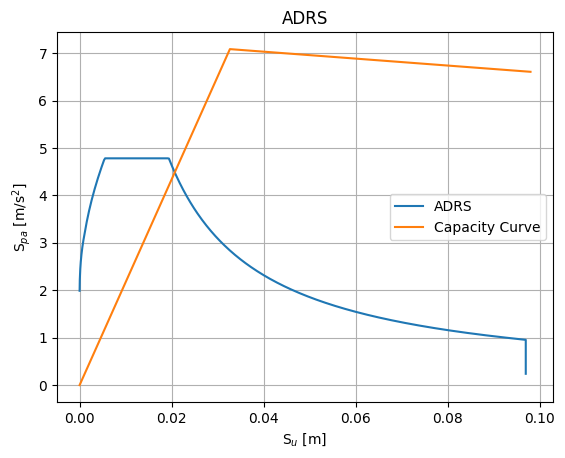

In [ ]:
### NOTHING TO BE CHANGED
# Calculate the displacement parameters per Griffith et al. (2003)
Delta1 = d1*Delta_star           # [m]
Delta2 = d2*Delta_star           # [m]

# Write vectors for plotting
x = np.array([[0],[Delta1],[Delta2]])
y = np.array([[0],[a_star*(1-Delta1)/Delta_star],[a_star*(1-Delta2)/Delta_star]])

## Compute ADRS
# Initialize vectors
T_vals = np.linspace(0,4,1000)
Su_vals = np.zeros((len(T_vals),1))
Se_vals = np.zeros((len(T_vals),1))
[S,Tb,Tc,Td] = spectrum_vals(soil_type)

for i in range(0,1000):
    omega = 2*np.pi/T_vals[i]                                           # natural frequency [rad/s]
    Se_vals[i] = RS(T_vals[i],agr,S,Tb,Tc,Td)                           # spectral acceleration [m/s^2]
    if T_vals[i] < Tc: 
        Ry = max(Se_vals[i]*m_star/Qs,1)                                # R relationship [-]
        wd_int = ((Ry-1)*Tc/T_vals[i] + 1)*Se_vals[i]/((omega**2)*Ry)   # displacement capacity [m]
        Su_vals[i] = min(wd_int,3*Se_vals[i]/omega**2)                  # spectral displacement capacity [m]
    else:
        Su_vals[i] = Se_vals[i]/(omega**2)                              # spectral displacement capacity [m]

## Plot capacity curve
# plot results
plt.figure()
plt.grid()
plt.plot(Su_vals,Se_vals,label='ADRS')
plt.plot(x,y,label='Capacity Curve')
plt.legend()
plt.xlabel('S$_u$ [m]')
plt.ylabel('S$_{pa}$ [m/s$^2$]')
plt.title('ADRS')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec31d9b1-b904-46de-90ff-bc7ed068e5e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>